<a href="https://colab.research.google.com/github/lukasbirki/Workshop-Classification/blob/main/Multi-Label%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  🤗 Demo Notebook 🤗
# <b><font color='#FFC000'>Multi-label</font></b> Text Classification in Python

This notebook provides materials for the workshop **Multi-class and Multi-label Text Classification in Python** for the [Workshop for Ukraine Series](https://sites.google.com/view/dariia-mykhailyshyna/main/r-workshops-for-ukraine).


**To access the notebook for multi-class classification,
visit [this link](https://colab.research.google.com/github/lukasbirki/Workshop-Classification/blob/main/Multi_Class_Classification.ipynb)**

This notebook reuses materials kindly provided by the following sources with an open-source license:

- [Fine-tuning BERT (and friends) for multi-label text classification](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb)

If you  have any questions, [contact Lukas](https://www.gesis.org/institut/mitarbeitendenverzeichnis/person/Lukas.Birkenmaier) via Mai.


# <b><font color='#FFC000'>Multi-label Classification</font></b>


For multi-label classification, we will use a notebook provided by [Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb) from Huggingface, who was kindly enough to share open-source materials ([MIT-License](https://opensource.org/license/mit/)).  

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")

# Convert the train dataset to a pandas DataFrame
df = pd.DataFrame(dataset['train'])

print(df.shape)
print(df.head())

Generating train split:   0%|          | 0/6838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3259 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/886 [00:00<?, ? examples/s]

(6838, 13)
              ID                                              Tweet  anger  \
0  2017-En-21441  “Worry is a down payment on a problem you may ...  False   
1  2017-En-31535  Whatever you decide to do make sure it makes y...  False   
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...   True   
3  2017-En-31436  Accept the challenges so that you can literall...  False   
4  2017-En-22195  My roommate: it's okay that we can't spell bec...   True   

   anticipation  disgust   fear    joy   love  optimism  pessimism  sadness  \
0          True    False  False  False  False      True      False    False   
1         False    False  False   True   True      True      False    False   
2         False     True  False   True  False      True      False    False   
3         False    False  False   True  False      True      False    False   
4         False     True  False  False  False     False      False    False   

   surprise  trust  
0     False   True  
1  

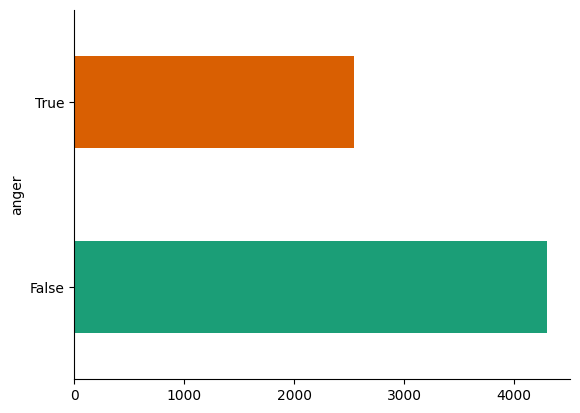

In [ ]:
# Distribution of Anger in the dataset

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('anger').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
example = dataset['train'][5]
example

{'ID': '2017-En-22190',
 'Tweet': "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu",
 'anger': False,
 'anticipation': False,
 'disgust': False,
 'fear': False,
 'joy': True,
 'love': False,
 'optimism': False,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': False}

The dataset consists of tweets, labeled with one or more emotions.

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

## Prepare Data

As models like BERT don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

What's a bit tricky is that we also need to provide labels to the model. For multi-label text classification, this is a matrix of shape (batch_size, num_labels). Also important: this should be a tensor of floats rather than integers, otherwise PyTorch' `BCEWithLogitsLoss` (which the model will use) will complain, as explained [here](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3).

In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["Tweet"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/6838 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
example['labels']

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['anticipation', 'optimism', 'trust']

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets](https://pytorch.org/docs/stable/data.html).

In [ ]:
encoded_dataset.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

This is also printed by the warning.

We set the `problem_type` to be "multi_label_classification", as this will make sure the appropriate loss function is used (namely [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)). We also make sure the output layer has `len(labels)` output neurons, and we set the id2label and label2id mappings.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


# Printing all the layers of the model. If you look at the last layer (way down), you can see the linear layer with 11 output nodes (for each label).
# Please keep in mind that we did not yet apply a sigmoid activation function to each on of the nodes, this will be done in the next code snippets
for name, module in model.named_modules():
    print(name, module)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
* a `Trainer` object (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [ ]:
batch_size = 8
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

We are also going to compute metrics while training. For this, we need to define a `compute_metrics` function, that returns a dictionary with the desired metric values.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

Let's verify a batch as well as a forward pass:

In [ ]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  1523,  4737,  2003,  1037,  2091,  7909,  2006,  1037,  3291,
         2017,  2089,  2196,  2031,  1005,  1012, 11830, 11527,  1012,  1001,
        14354,  1001,  4105,  1001,  4737,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.7896, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.8847,  0.0100, -0.0074, -0.1218,  0.5916, -0.2456,  0.1068,  0.3791,
         -0.3880,  0.3121, -0.3998]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Let's start training!

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.405900,0.319687,0.684184,0.784079,0.266366
2,0.284500,0.301684,0.700180,0.790475,0.292325
3,0.241200,0.301302,0.705676,0.797658,0.287810
4,0.216700,0.311435,0.710088,0.804313,0.277652
5,0.191700,0.308299,0.714566,0.806789,0.286682


TrainOutput(global_step=4275, training_loss=0.26061892682348775, metrics={'train_runtime': 335.1823, 'train_samples_per_second': 102.004, 'train_steps_per_second': 12.754, 'total_flos': 2249123476753920.0, 'train_loss': 0.26061892682348775, 'epoch': 5.0})

Please note that the pure accuracy is not the best metric for our case, as it only accounts for exact matches. Instead, we should evaluate the average (micro) F1 Score, which is sufficient (around .71)

## Evaluate

After training, we evaluate our model on the validation set.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.30829891562461853,
 'eval_f1': 0.7145659637076999,
 'eval_roc_auc': 0.8067894420080061,
 'eval_accuracy': 0.2866817155756208,
 'eval_runtime': 2.4345,
 'eval_samples_per_second': 363.929,
 'eval_steps_per_second': 45.594,
 'epoch': 5.0}

## Inference

Let's test the model on a new sentence:

In [ ]:
text = "I'm sad I can finally train a model for multi-label classification"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

The logits that come out of the model are of shape (batch_size, num_labels). As we are only forwarding a single sentence through the model, the `batch_size` equals 1. The logits is a tensor that contains the (unnormalized) scores for every individual label.

In [ ]:
logits = outputs.logits
logits.shape #torch.Size([1, 11])

torch.Size([1, 11])

To turn them into actual predicted labels, we first apply a sigmoid function independently to every score, such that every score is turned into a number between 0 and 1, that can be interpreted as a "probability" for how certain the model is that a given class belongs to the input text.

Next, we use a threshold (typically, 0.5) to turn every probability into either a 1 (which means, we predict the label for the given example) or a 0 (which means, we don't predict the label for the given example).

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['pessimism', 'sadness']
